In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


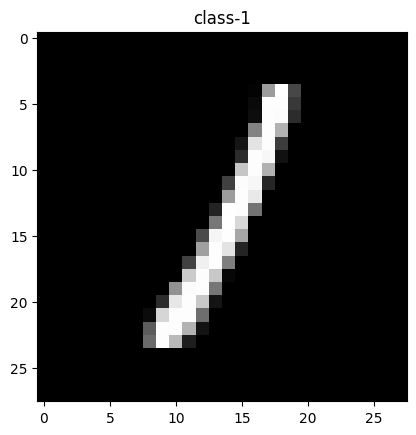

In [3]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels


dataset_path = r"C:\Users\DEBARSHI\Documents\Programs\Python\Deep Learning and Natural Language Processing, DA345\Assignments\Assignment 2\data"

train_image_filename = os.path.join(dataset_path, 'train-images-idx3-ubyte.gz')
train_label_filename = os.path.join(dataset_path, 'train-labels-idx1-ubyte.gz')

test_image_filename = os.path.join(dataset_path, 't10k-images-idx3-ubyte.gz')
test_label_filename = os.path.join(dataset_path, 't10k-labels-idx1-ubyte.gz')

train_images = read_images(train_image_filename)
train_labels = read_labels(train_label_filename)

print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images(test_image_filename)
test_labels = read_labels(test_label_filename)

print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))



rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()



In [4]:
train_images_tensor=torch.tensor(train_images,dtype=torch.float32)/255.0
train_labels_tensor=torch.tensor(train_labels,dtype=torch.long)
test_images_tensor=torch.tensor(test_images,dtype=torch.float32)/255.0
test_labels_tensor=torch.tensor(test_labels,dtype=torch.long)

In [5]:
batch_size=64
train_data=TensorDataset(train_images_tensor,train_labels_tensor)
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_data=TensorDataset(test_images_tensor,test_labels_tensor)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [6]:
class TwoLayerModel(nn.Module):
    def __init__(self,input_size=784,hidden_size=128,output_size=10):
        super(TwoLayerModel,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size)
        self.fc2=nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [7]:
model=TwoLayerModel().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

In [8]:
num_epochs=10
train_accuracies=[]
test_accuracies=[]

for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    train_correct=0
    train_total=0

    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        outputs=model(images)
        loss=criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _, predicted=torch.max(outputs.data, 1)
        train_total+=labels.size(0)
        train_correct+=(predicted==labels).sum().item()

    train_loss=running_loss/len(train_loader)
    train_acc=100*train_correct/train_total
    train_accuracies.append(train_acc) 

    model.eval()
    test_correct=0
    test_total=0

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)
            _,predicted=torch.max(outputs.data, 1)
            test_total+=labels.size(0)
            test_correct+=(predicted == labels).sum().item()

    test_acc=100*test_correct / test_total
    test_accuracies.append(test_acc)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, "f"Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

Epoch [1/10], Loss: 0.4701, Train Accuracy: 86.97%, Test Accuracy: 92.58%
Epoch [2/10], Loss: 0.2305, Train Accuracy: 93.47%, Test Accuracy: 94.57%
Epoch [3/10], Loss: 0.1725, Train Accuracy: 95.11%, Test Accuracy: 95.57%
Epoch [4/10], Loss: 0.1376, Train Accuracy: 96.06%, Test Accuracy: 96.29%
Epoch [5/10], Loss: 0.1153, Train Accuracy: 96.70%, Test Accuracy: 96.69%
Epoch [6/10], Loss: 0.0998, Train Accuracy: 97.17%, Test Accuracy: 96.67%
Epoch [7/10], Loss: 0.0868, Train Accuracy: 97.55%, Test Accuracy: 97.07%
Epoch [8/10], Loss: 0.0781, Train Accuracy: 97.80%, Test Accuracy: 97.12%
Epoch [9/10], Loss: 0.0701, Train Accuracy: 98.06%, Test Accuracy: 97.26%
Epoch [10/10], Loss: 0.0637, Train Accuracy: 98.18%, Test Accuracy: 97.27%


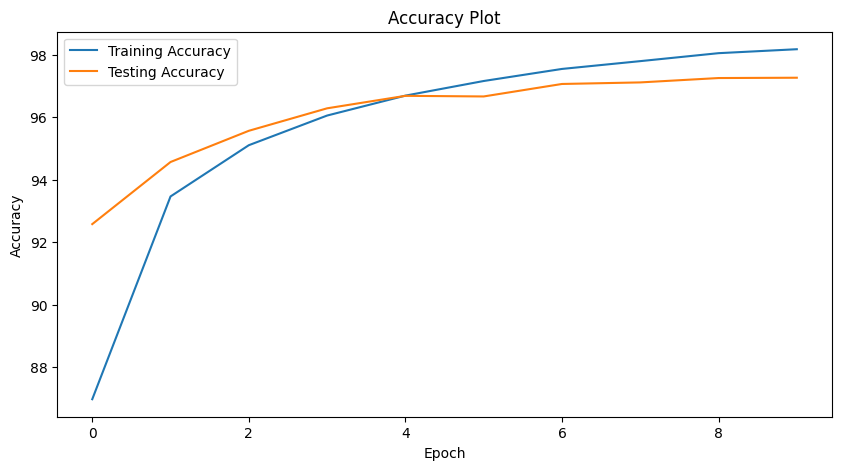

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

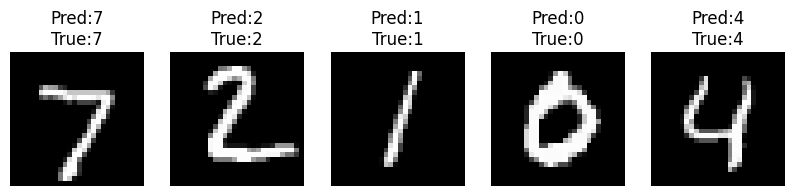

In [10]:
def visualize_predictions(model,data_loader,num_images):
    model.eval()
    images,labels=next(iter(test_loader))
    images=images.to(device)
    labels=labels.to(device)

    with torch.no_grad():
        outputs=model(images)
        _,predicted=torch.max(outputs, 1)
    images=images.cpu()
    predicted=predicted.cpu()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(images[i].view(28, 28),cmap='gray')
        plt.title(f"Pred:{predicted[i]}\nTrue:{labels[i]}")
        plt.axis('off')
    plt.show()

visualize_predictions(model, test_loader, num_images=5)
    